# Assignment 2

This assignment contains 4 sections:
- Harris Corner Detector
- Invariance of SIFT Features
    - Invariance Under Scale
    - Invariance Under Rotation
- Image Stitching
- Image Matching

In [22]:
# All imports
from os.path import abspath, join
import cv2
from cv2 import imread, filter2D, normalize, NORM_MINMAX, IMREAD_GRAYSCALE, Sobel, CV_32F, resize, BFMatcher
import numpy as np
from scipy.ndimage import gaussian_filter as gauss_filter
from matplotlib.pyplot import subplots, imshow, figure


# The path to the images is the relative path in this repo `./images`
image_folder = abspath('./images')
print("image folder: " + image_folder)

image folder: /home/alix/Desktop/school/semester_5/ECSE-415/assignment2/images


## Harris Corner Detector

In [23]:
# getting the images

checkerboard_path = join(image_folder, 'q1.1.jpg')
checkerboard_image = imread(checkerboard_path, IMREAD_GRAYSCALE)

shapes_path = join(image_folder, 'q1.2.png')
shapes_image = imread(shapes_path, IMREAD_GRAYSCALE)

house_path = join(image_folder, 'q1.3.png')
house_image = imread(house_path, IMREAD_GRAYSCALE)

In [24]:
# Declaring filters

gaussian_filter = gauss_filter(np.array([[0,0,0], [0,1,0], [0,0,0]], float), 2)

In [25]:
# function for applying Harris Corner Detection

def harris_detection(image, threshold):
    """
    This function will apply a Harris corner detection filter to the inputted image. It will follow the following steps:
    - do a copy of the image to not modify the original one
    - apply a gaussian filter
    - apply a horizontal and vertical sobel filter
    - apply a cornerness response function
    - apply a non-maximum suppression
    - normalizes the image
    - apply a threshold on the image
    @param image: the image to apply the Harris Corner Detection on (in numpy array format)
    @param threshold: the value of the threshold (between 0 and 255)
    @returns the transformed image in numpy array format
    """
    
    # creating a copy so that we don't alter the original image
    copy = np.array(image, copy=True)
    returned_copy = np.array(image, copy=True)

    # applying gaussian filter
    copy = filter2D(copy, -1, gaussian_filter)

    # applying sobel filter
    vertical_sobel_image = Sobel(copy, CV_32F, 0, 1)
    horizontal_sobel_image = Sobel(copy, CV_32F, 1, 0)

    # squaring sobel filters
    squared_vertical = vertical_sobel_image ** 2
    squared_horizontal = horizontal_sobel_image ** 2
    temp_multiplied = vertical_sobel_image * horizontal_sobel_image

    # applying gaussian filters to all of these squared values
    temp_multiplied = filter2D(temp_multiplied, -1, gaussian_filter)
    squared_vertical = filter2D(squared_vertical, -1, gaussian_filter)
    squared_horizontal = filter2D(squared_horizontal, -1, gaussian_filter)

    # cornerness response function
    copy = (squared_vertical * squared_horizontal) - (temp_multiplied ** 2) - (0.05 * ((vertical_sobel_image + horizontal_sobel_image) ** 2))

    zeros = np.zeros(copy.shape)

    # non-maximum suppression
    for i, v1 in enumerate(copy):
        for j, v2 in enumerate(v1):
            for k in range(-1, 2):
                for l in range(-1, 2):
                    if i + k >= 0 and j + l >= 0 and i + k < copy.shape[0] and j + l < copy.shape[1] and v2 < copy[i + k, j + l]:
                        continue
                    zeros[i, j] = v2

    copy = zeros
    
    # normalizing image
    copy = normalize(copy, None, 0, 255, NORM_MINMAX)

    # thresholding image
    features = np.where(copy >= threshold)
    
    # adding red circles to image
    returned_copy = cv2.cvtColor(returned_copy,cv2.COLOR_GRAY2RGB)
    for feature in zip(*features[::-1]):
        cv2.circle(returned_copy, feature, 3, (255,0,0), -1)

    return returned_copy


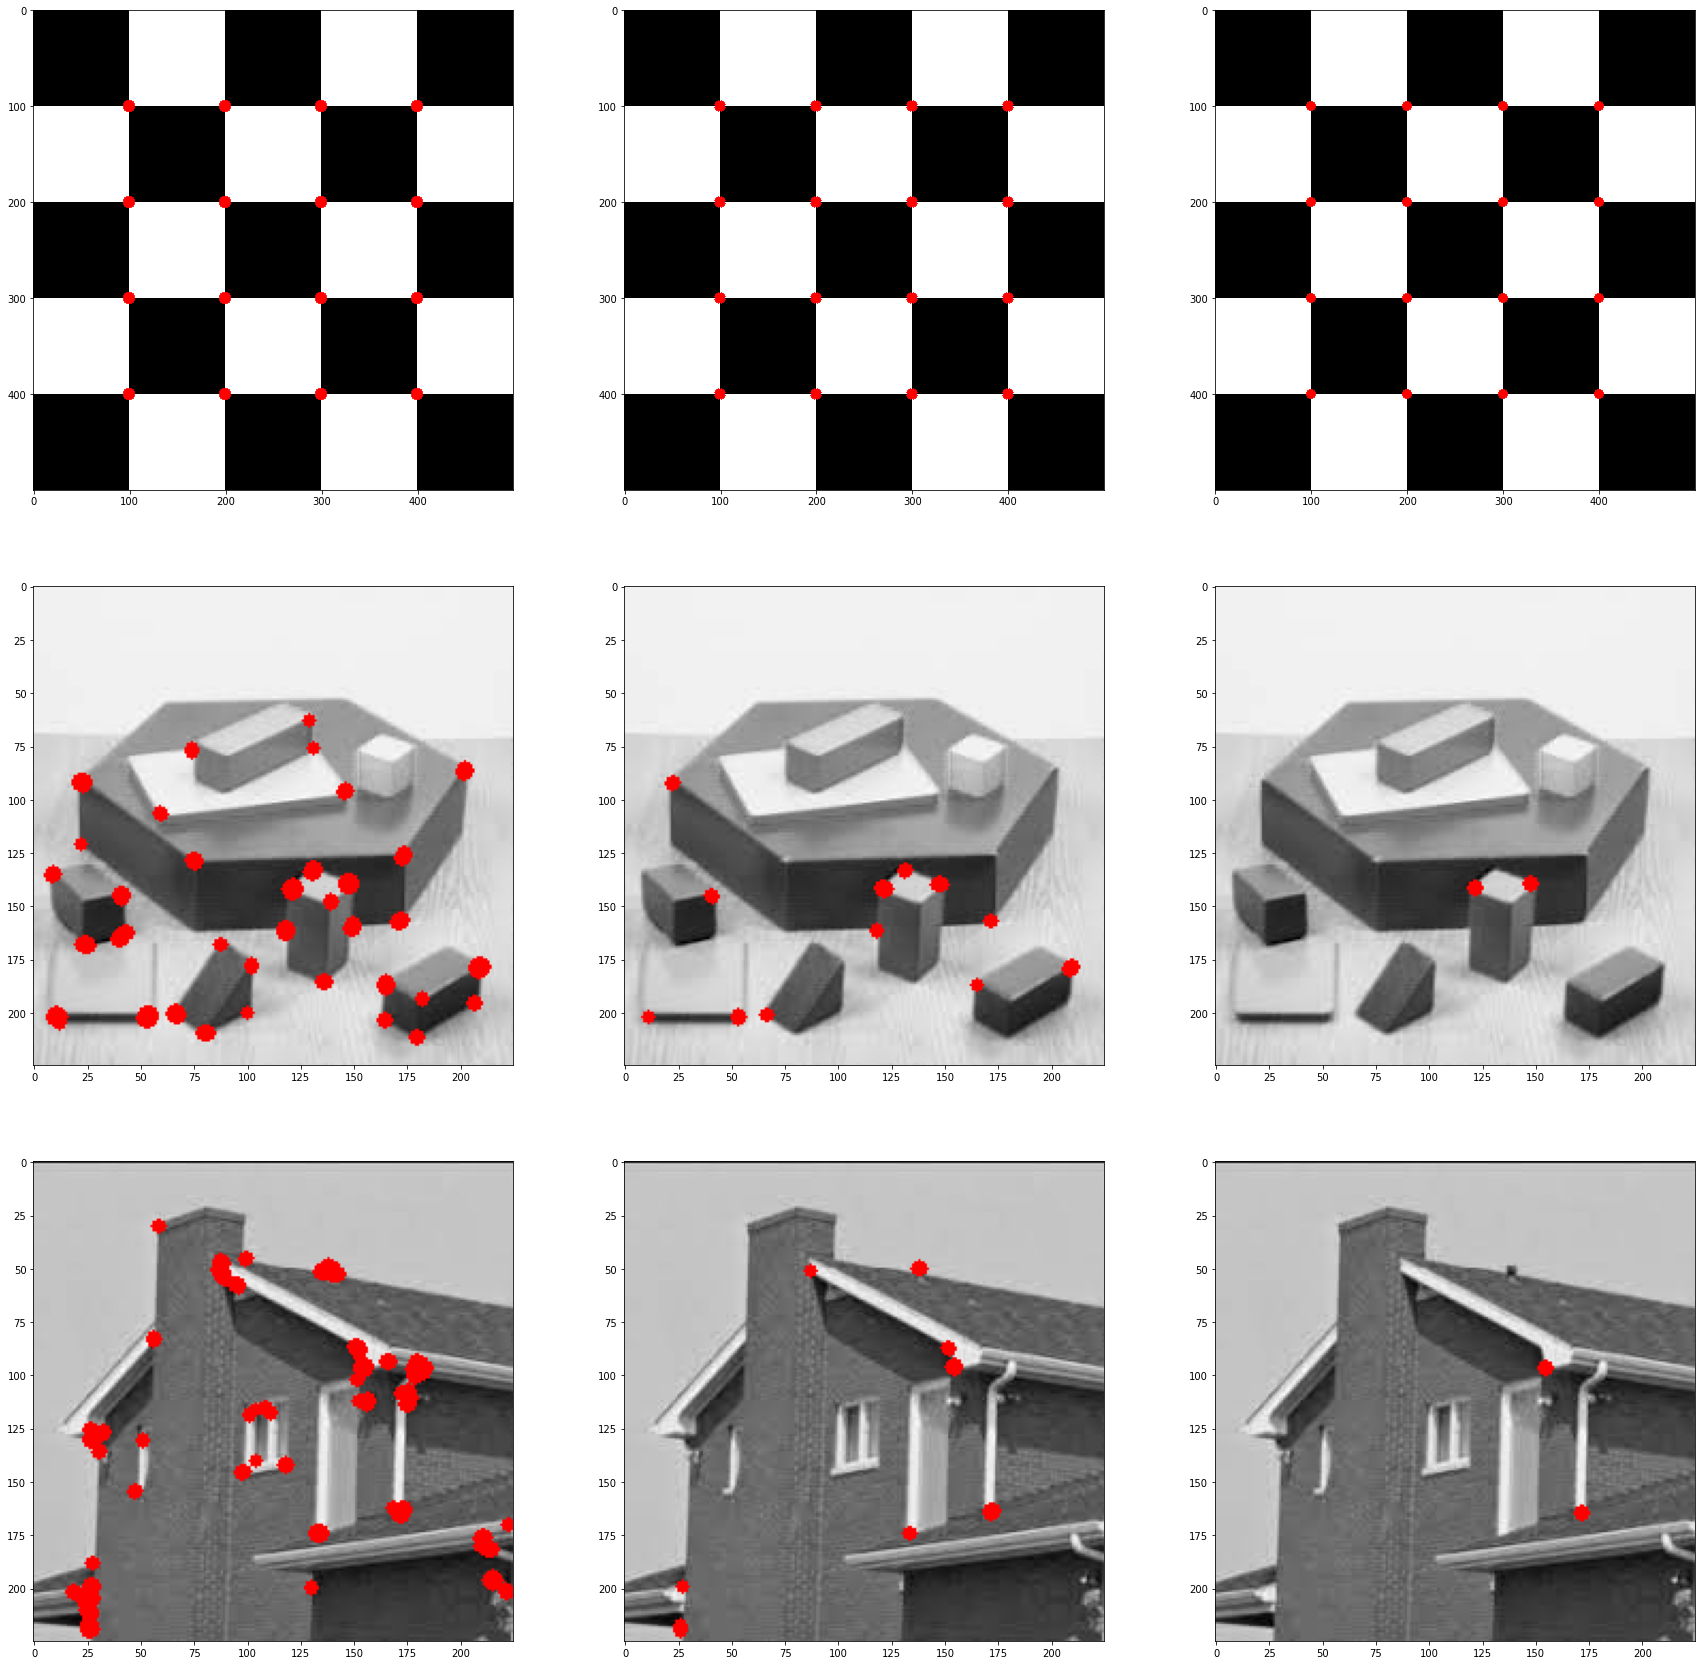

In [26]:
f, harris = subplots(3, 3, figsize=(30, 30))

# checkerboard with 15 threshold
harris[0, 0].imshow(harris_detection(checkerboard_image, 20))

# checkerboard with 19 threshold
harris[0, 1].imshow(harris_detection(checkerboard_image, 75))

# checkerboard with 200 threshold
harris[0, 2].imshow(harris_detection(checkerboard_image, 150))

# shapes with 50 threshold
harris[1, 0].imshow(harris_detection(shapes_image, 20))

# shapes with 100 threshold
harris[1, 1].imshow(harris_detection(shapes_image, 75))

# shapes with 200 threshold
harris[1, 2].imshow(harris_detection(shapes_image, 150))

# house with 50 threshold
harris[2, 0].imshow(harris_detection(house_image, 20))

# house with 100 threshold
harris[2, 1].imshow(harris_detection(house_image, 75))

# house with 200 threshold
harris[2, 2].imshow(harris_detection(house_image, 150))


## Invariance of SIFT Features: Invariance Under Scale

In [27]:
# SIFT feature detection

sift = cv2.xfeatures2d.SIFT_create()

original_keypoints, original_descriptors = sift.detectAndCompute(house_image, None)

0.2 scale
Number of keypoints: 20
Number of matches: 20

0.8 scale
Number of keypoints: 141
Number of matches: 141

2 scale
Number of keypoints: 273
Number of matches: 273

5 scale
Number of keypoints: 286
Number of matches: 286



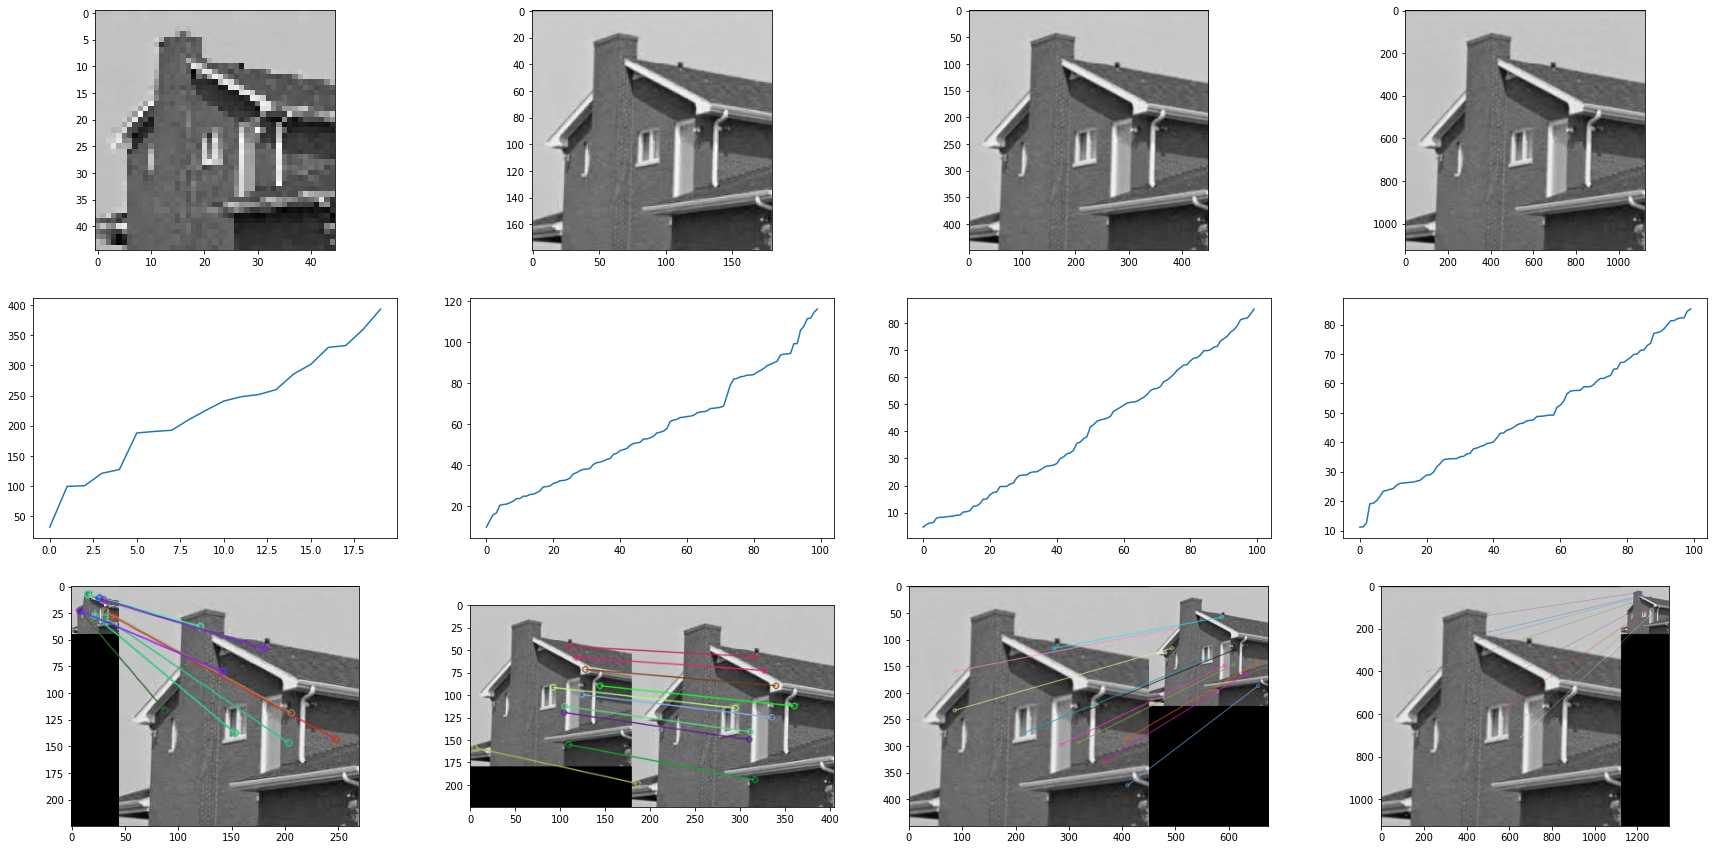

In [28]:
matcher = BFMatcher()

f, scaled = subplots(3, 4, figsize=(30, 15))

for i, v in enumerate([0.2, 0.8, 2, 5]):
    
    # scaling image
    scaled_image = resize(house_image, (0, 0), fx=v, fy=v)

    # getting the descriptors
    keypoints, descriptors = sift.detectAndCompute(scaled_image, None)

    print(str(v) + " scale")
    print("Number of keypoints: " + str(len(keypoints)))

    # getting matches with the original image
    matches = list(matcher.match(descriptors, original_descriptors))

    print("Number of matches: " + str(len(matches)))
    print("")
    
    # sorting the matches
    matches.sort(key = lambda x:x.distance)

    distances = [x.distance for x in matches[:100]]

    scaled[0, i].imshow(scaled_image, cmap='gray')
    scaled[1, i].plot(range(len(distances)), distances)
    scaled[2, i].imshow(cv2.drawMatches(scaled_image, keypoints, house_image, original_keypoints, matches[:10], None, flags=2))
    

There are a lot less features when images are scaled down because there are less pixels to get corners from. For example, the image scaled with a 0.2 factor got 20 keypoints and the image with a factor of 5 got 286 keypoints. We can also see that downscaling images has a bigger effect on the number of keypoints than upscaling images, because there was a loss of data when downscaling, but there wasn't really a creation of data for upscaling, the current pixels just got divided in smaller shares without really changing much their value.

For the same reason, the matching distance is generally higher with downscaling images, because the loss of data will make features more different from one another.

## Invariance of SIFT Features: Invariance Under Rotation

10 rotation
Number of keypoints: 211
Number of matches: 211

90 rotation
Number of keypoints: 195
Number of matches: 195

130 rotation
Number of keypoints: 190
Number of matches: 190

180 rotation
Number of keypoints: 195
Number of matches: 195



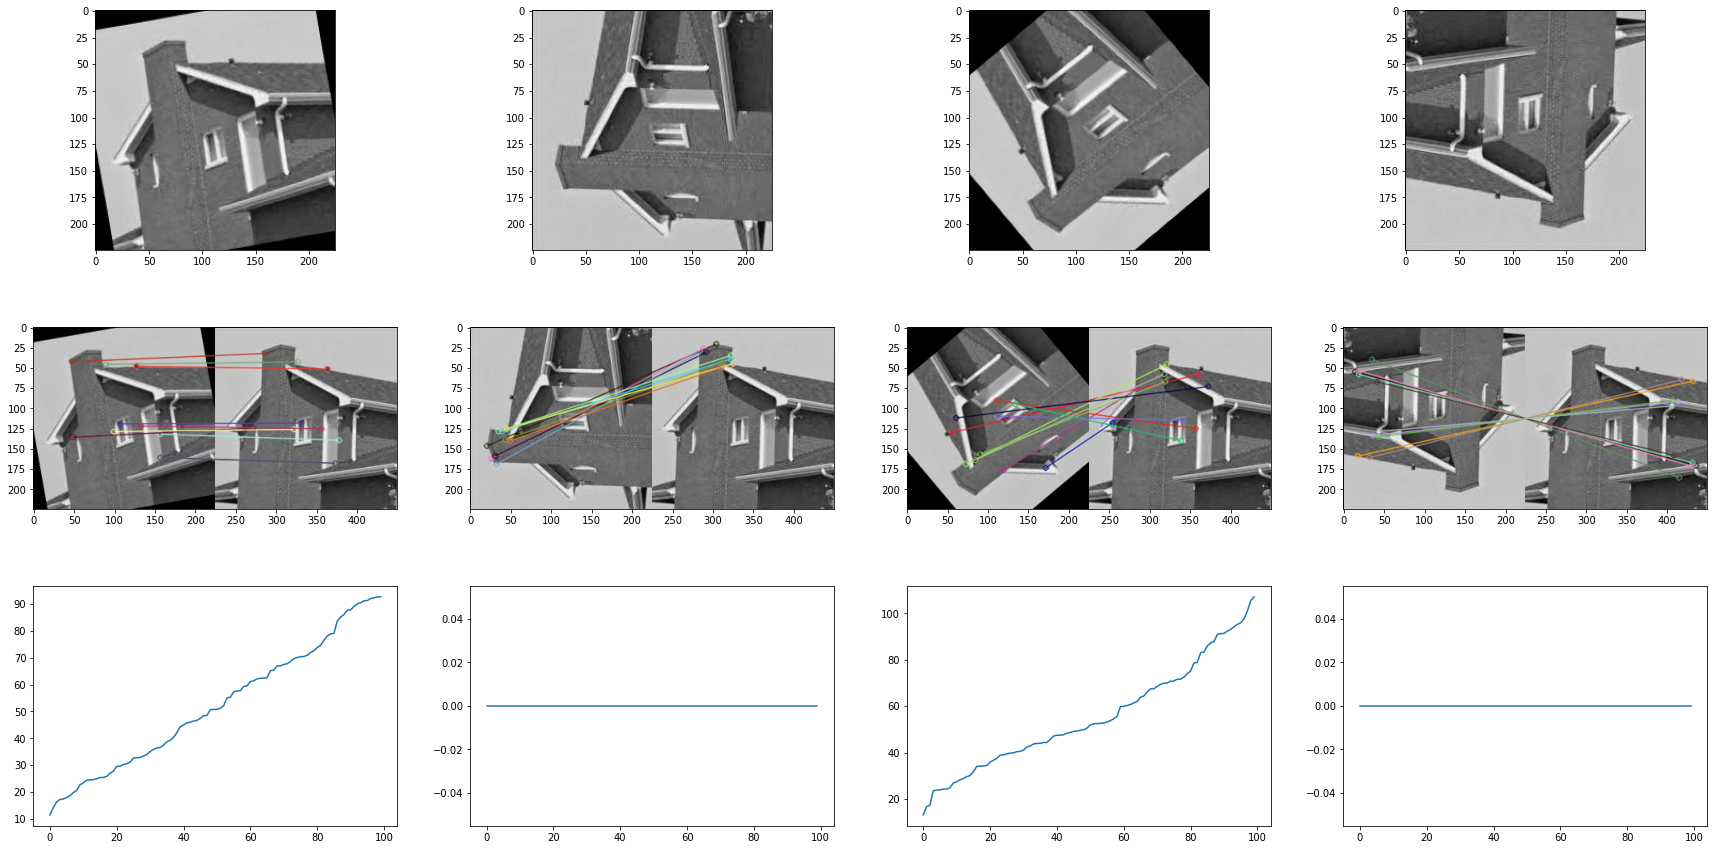

In [29]:
f, rotated = subplots(3, 4, figsize=(30, 15))

for i, v in enumerate([10, 90, 130, 180]):
    
    # rotation matrix
    matrix = cv2.getRotationMatrix2D((house_image.shape[0]/2, house_image.shape[1] / 2), v, 1)
    rotated_image = cv2.warpAffine(house_image, matrix, house_image.shape)
    
    # getting the keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(rotated_image, None)

    print(str(v) + " rotation")
    print("Number of keypoints: " + str(len(keypoints)))

    # getting matches with the original image
    matches = list(matcher.match(descriptors, original_descriptors))

    print("Number of matches: " + str(len(matches)))
    print("")
    
    # sorting the matches
    matches.sort(key = lambda x:x.distance)

    distances = [x.distance for x in matches[:100]]

    rotated[0, i].imshow(rotated_image, cmap='gray')
    rotated[1, i].imshow(cv2.drawMatches(rotated_image, keypoints, house_image, original_keypoints, matches[:10], None, flags=2))
    rotated[2, i].plot(range(len(distances)), distances)

For angles of rotation 10 and 130, the matching distance graphs are similar to the ones in the scaling exercice earlier on, as they are mostly non-zero. Images where the rotation angle is a multiple of 90 only have matching distances of 0 and have the same number of keypoints. This is because they are the same image, but read in another direction, there is no loss or change in pixel values (other than considering that they are flipped). On the contrary, images where the rotation angle is not a multiple of 90 degrees, a transformation to pixel values happened because an orthogonal line cannot be represented the same in pixels as a diagonal line, and thus, the matching will (probably) not have a matching distance of zero.

## Image Stitching

In [30]:
def convert_color(image):
    """
    Converts opencv color ordering to matplotlib color ordering
    @param image: the color image to convert
    @returns the converted image
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [31]:
# getting the images

panorama1_path = join(image_folder, 'panorama1.png')
panorama1_image = imread(panorama1_path)

panorama2_path = join(image_folder, 'panorama2.png')
panorama2_image = imread(panorama2_path)

panorama3_path = join(image_folder, 'panorama3.png')
panorama3_image = imread(panorama3_path)

In [32]:
# getting the keypoints and descriptors

keypoints1, descriptors1 = sift.detectAndCompute(panorama1_image, None)

keypoints2, descriptors2 = sift.detectAndCompute(panorama2_image, None)

keypoints3, descriptors3 = sift.detectAndCompute(panorama3_image, None)

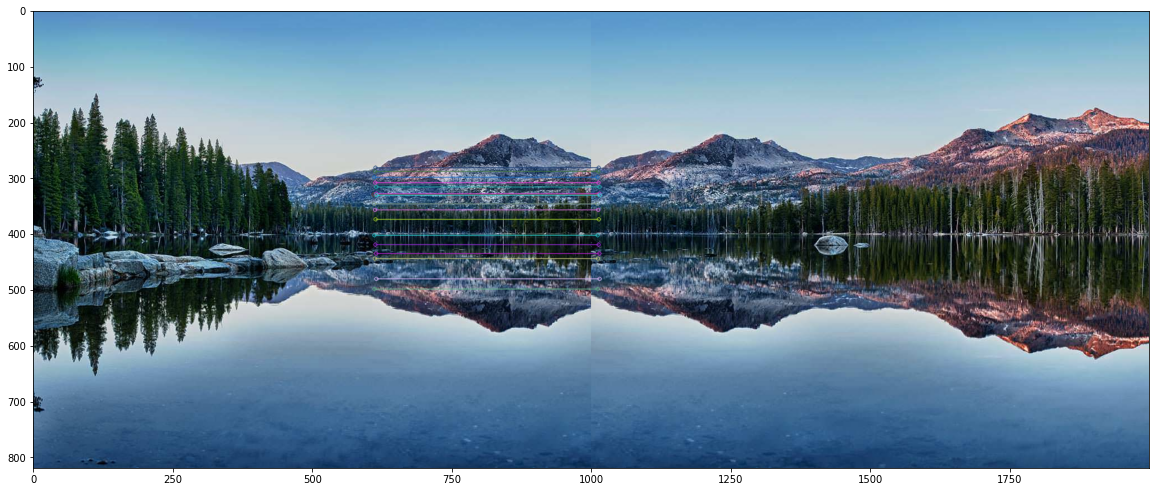

In [33]:
matches_panorama1_2 = list(matcher.match(descriptors1, descriptors2))

# sorting the matches
matches_panorama1_2.sort(key = lambda x:x.distance)

figure(figsize = (20,10))

imshow(convert_color(cv2.drawMatches(panorama1_image, keypoints1, panorama2_image, keypoints2, matches_panorama1_2[:20], None, flags=2)))

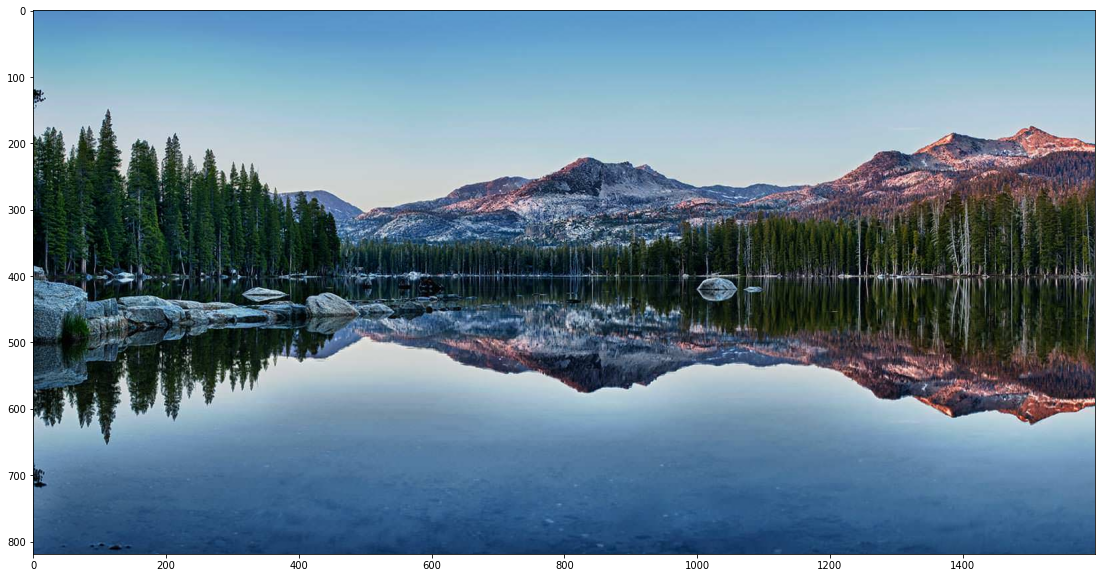

In [34]:
# finding all significant matches
significant_matches = [i for i in matches_panorama1_2 if i.distance < 1000]

# dividing into right and left keypoints
left_keypoints = np.float32([keypoints1[match.queryIdx].pt for match in significant_matches])
right_keypoints = np.float32([keypoints2[match.trainIdx].pt for match in significant_matches])

# find the homography
homography, __ = cv2.findHomography(left_keypoints, right_keypoints, cv2.RANSAC, 4)

# stitching images
panorama12_image = cv2.warpPerspective(panorama1_image, homography, (panorama2_image.shape[1]+ panorama1_image.shape[1],panorama1_image.shape[0]))

# getting the merging limit
limit = -1
for i, v in enumerate(panorama12_image[0]):
    if v.tolist() == [0, 0, 0]:
        limit = i
        break

# stitching with linear blending
returned_image = np.zeros((panorama1_image.shape[0], panorama1_image.shape[1] * 2 - limit, panorama1_image.shape[2]))
returned_image[:, :panorama1_image.shape[1] - limit] = panorama1_image[:, :panorama1_image.shape[1] - limit]
# linear blending here
returned_image[:, panorama1_image.shape[1] - limit: panorama1_image.shape[1]] = cv2.addWeighted(panorama1_image[:, panorama1_image.shape[1] - limit:], 0.5, panorama2_image[:, :limit], 0.5, 0)
returned_image[:,panorama1_image.shape[1]:] = panorama2_image[:, limit:]
returned_image = returned_image.astype(np.uint8)

figure(figsize = (20,10))

imshow(convert_color(returned_image))
panorama12_image = returned_image

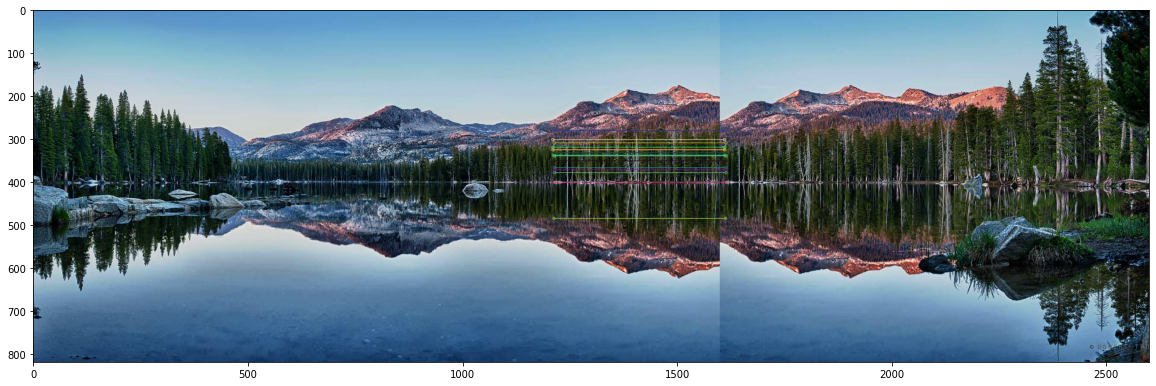

In [35]:
# computing SIFT keypoints and descriptors
keypoints12, descriptors12 = sift.detectAndCompute(panorama12_image, None)

matches_panorama12_3 = list(matcher.match(descriptors12, descriptors3))

# sorting the matches
matches_panorama12_3.sort(key = lambda x:x.distance)

figure(figsize = (20,10))

imshow(convert_color(cv2.drawMatches(panorama12_image, keypoints12, panorama3_image, keypoints3, matches_panorama12_3[:20], None, flags=2)))


(819, 400, 3)
(819, 400, 3)


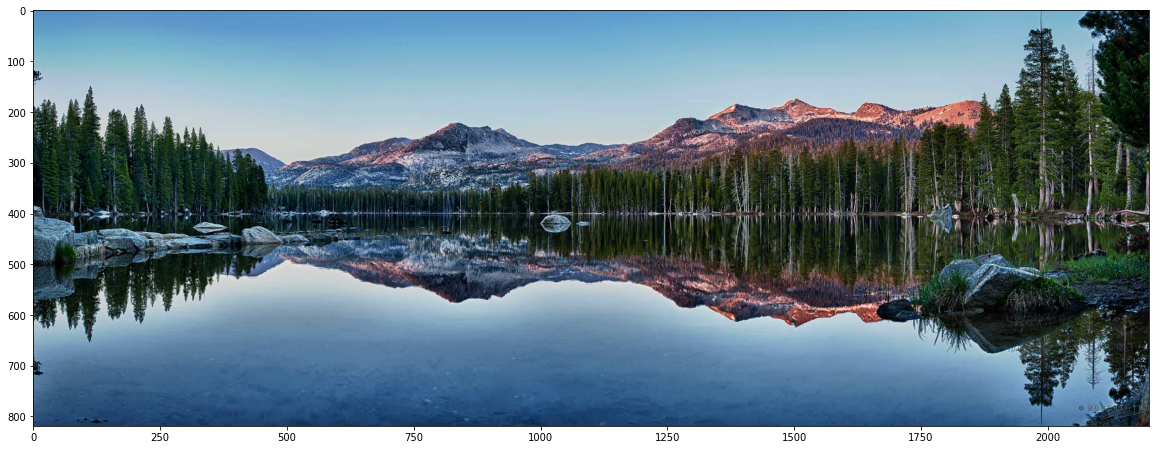

In [36]:
# finding all significant matches
significant_matches = [i for i in matches_panorama12_3 if i.distance < 1000]

# dividing into right and left keypoints
left_keypoints = np.float32([keypoints12[match.queryIdx].pt for match in significant_matches])
right_keypoints = np.float32([keypoints3[match.trainIdx].pt for match in significant_matches])

# find the homography
homography, __ = cv2.findHomography(right_keypoints, left_keypoints, cv2.RANSAC, 4)

# stitching images
merged_image = cv2.warpPerspective(panorama3_image, homography, (panorama3_image.shape[1]+panorama12_image.shape[1],panorama3_image.shape[0]))

# getting the merging limit
limit = -1
for i, v in enumerate(merged_image[0]):
    if v.tolist() != [0, 0, 0]:
        limit = i
        break
limit = panorama12_image.shape[1] - limit

# stitching with linear blending
returned_image = np.zeros((panorama12_image.shape[0], panorama12_image.shape[1] + panorama3_image.shape[1] - limit, panorama12_image.shape[2]))
returned_image[:, :panorama12_image.shape[1] - limit] = panorama12_image[:, :panorama12_image.shape[1] - limit]
# linear blending here
print(panorama12_image[:, panorama12_image.shape[1] - limit:].shape)
print(panorama3_image[:, :limit].shape)
returned_image[:, panorama12_image.shape[1] - limit: panorama12_image.shape[1]] = cv2.addWeighted(panorama12_image[:, panorama12_image.shape[1] - limit:], 0.5, panorama3_image[:, :limit], 0.5, 0)
returned_image[:,panorama12_image.shape[1]:] = panorama3_image[:, limit:]
returned_image = returned_image.astype(np.uint8)

figure(figsize = (20,10))

imshow(convert_color(returned_image))

Generally, one would use pyramidal blending when the keypoints wouldn't superpose by linear transformations, which would make the image blurry when using linear blending. Pyramidal blending would reconstruct the images from Laplacian transforms to avoid this.
For our case, this would be a waiste of computing power because it seems like the three original images are a cropping of an original image, so they superpose perfectly.

## Image Matching

Image 0 has 11 significant matches at 100 distance threshold.
Image 0 has 371 significant matches at 200 distance threshold.
Image 1 has 10 significant matches at 100 distance threshold.
Image 1 has 384 significant matches at 200 distance threshold.
Image 2 has 26 significant matches at 100 distance threshold.
Image 2 has 216 significant matches at 200 distance threshold.


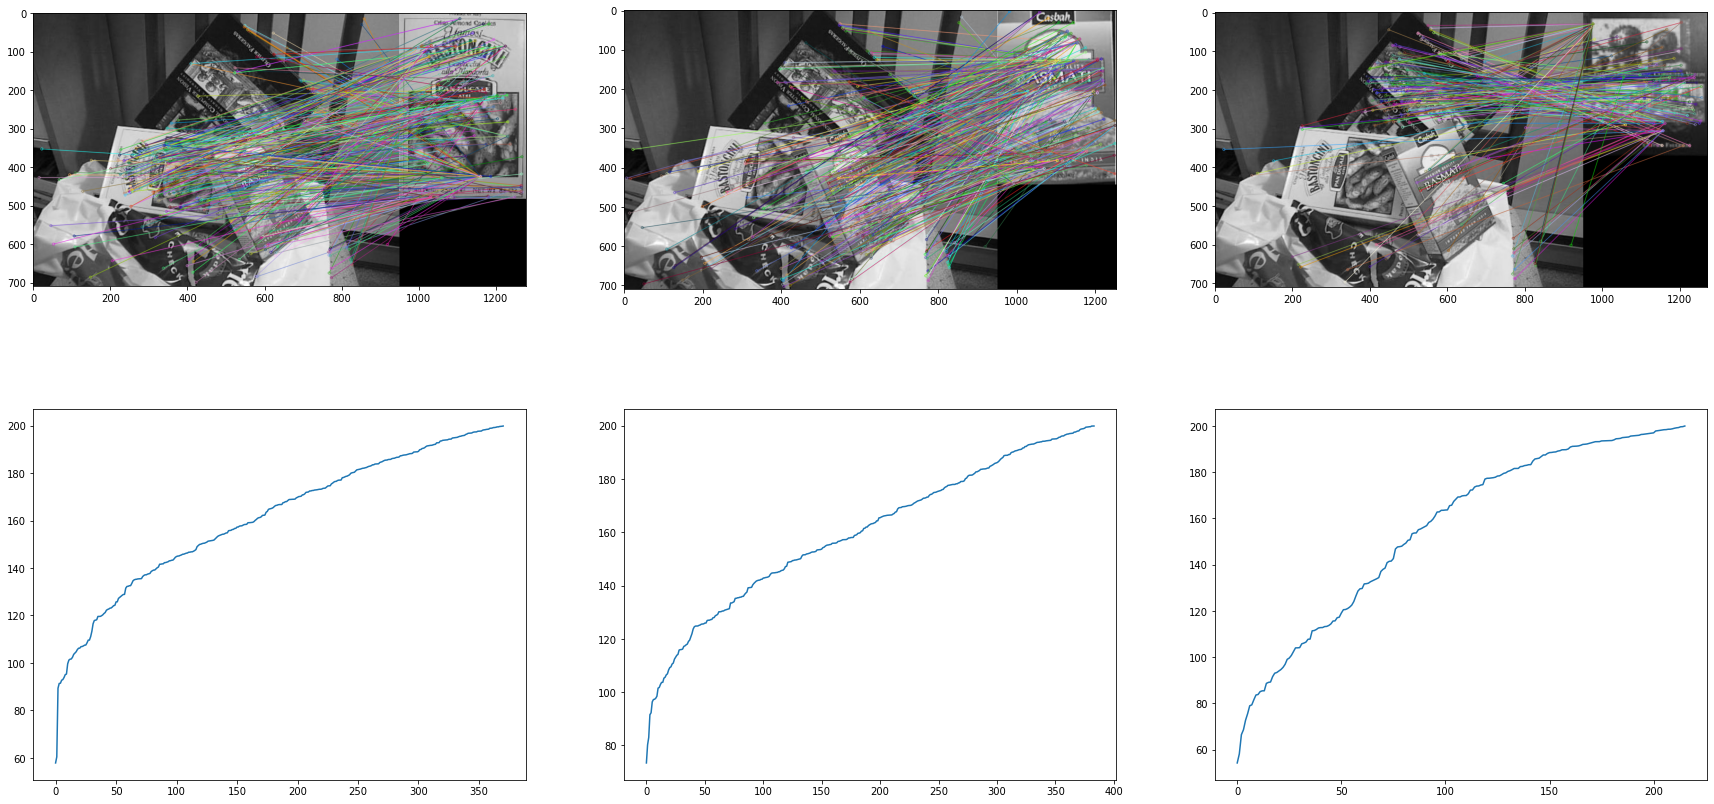

In [37]:
# getting the original image
scene_path = join(image_folder, 'q4.png')
scene_image = imread(scene_path)

# getting SIFT keypoints and descriptors of the original image
keypoints_scene, descriptors_scene = sift.detectAndCompute(scene_image, None)

f, matching = subplots(2, 3, figsize=(30, 15))

for i, v in enumerate(['q4_1.png', 'q4_2.png', 'q4_3.png']):

    # getting the images
    feature_path = join(image_folder, v)
    feature_image = imread(feature_path)

    # getting SIFT keypoints and descriptors
    keypoints_feature, descriptors_feature = sift.detectAndCompute(feature_image, None)

    # finding matches and sorting them
    matches_feature = list(matcher.match(descriptors_scene, descriptors_feature))
    matches_feature.sort(key = lambda x:x.distance)

    # finding all significant matches
    significant_matches_100 = [i for i in matches_feature if i.distance < 100]
    significant_matches_200 = [i for i in matches_feature if i.distance < 200]

    # array of distances
    distances = [x.distance for x in significant_matches_200]

    print("Image " + str(i) + " has " + str(len(significant_matches_100)) + " significant matches at 100 distance threshold.")
    print("Image " + str(i) + " has " + str(len(significant_matches_200)) + " significant matches at 200 distance threshold.")

    matching[0, i].imshow(cv2.drawMatches(scene_image, keypoints_scene, feature_image, keypoints_feature, significant_matches_200, None, flags=2))
    matching[1, i].plot(range(len(distances)), distances)
    



All the sub-images are present in the bigger image, as they all have 200+ significative matches in SIFT keypoints at a distance of 200 threshold. The two first objects performed better at a lowerthreshold, and the third one performed better at a lower threshold.

SSD would probably not work as well because the distances are not the same between features when they are turned. For example, the two first images would perform a lot poorer because they have a lot matches at a higher distance threshold, but lesser at a lower threshold. The third image would perform well in that scenario though.